In [130]:
import argparse
from pathlib import Path
import time
import cv2
from segment_anything import sam_model_registry, SamPredictor
import numpy as np
from matplotlib import pyplot as plt
import open3d as o3d
from utils.annotationdataset import AnnotationDataset
from utils.annotationimage import AnnotationImage, AnnotationObject
from utils.annotationscene import AnnotationScene
from utils.voxelgrid import VoxelGrid
import pandas as pd
import pickle
from scipy.spatial.distance import cdist
from copy import deepcopy   
from scipy.ndimage import generic_filter

In [131]:
sam_checkpoint = "model_checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [132]:
scene = AnnotationScene(None, None, None, None, None)
scene.scene_from_pickle("debug_data_promptgeneration")

In [133]:
def identify_voxels_in_scene(scene, vg):
    intrinsics = o3d.camera.PinholeCameraIntrinsic(
        scene.img_width, 
        scene.img_height, 
        scene.camera_intrinsics[0, 0], 
        scene.camera_intrinsics[1, 1], 
        scene.camera_intrinsics[0, 2], 
        scene.camera_intrinsics[1, 2])
    vis = o3d.visualization.Visualizer()

    voxel_correspondences = {tuple(voxel.grid_index): [] for voxel in vg.o3d_grid.get_voxels()}
    #iterate over all images that have accepted annotations
    for image in scene.annotation_images.values():
        if not image.annotation_accepted:
            continue

        print("calculating correspondences for image")

        start_time = time.time()
        # get camera pose
        pose = image.camera_pose

        #project voxel grid into image space
        vis.create_window(width=scene.img_width, height=scene.img_height, visible=False)
        vis.add_geometry(vg.o3d_grid)
        view_control = vis.get_view_control()
        param = o3d.camera.PinholeCameraParameters()
        param.intrinsic = intrinsics
        param.extrinsic = np.linalg.inv(pose.tf)
        view_control.convert_from_pinhole_camera_parameters(param, True)
        #define background color
        vis.get_render_option().background_color = np.array([0, 0, 0])
        vis.poll_events()
        vis.update_renderer()
        # vis.run()
        rgb = vis.capture_screen_float_buffer(True)
        vis.destroy_window()

        # #show rgb image
        # rgb_cv = (np.asarray(rgb)*255).astype(np.uint8)
        # cv2.imshow("rgb", cv2.cvtColor(rgb_cv, cv2.COLOR_RGB2BGR))
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        print(f"projection time: {time.time()-start_time}")

        grid_position = np.array(rgb)
        grid_position[:,:,0] = grid_position[:,:,0] * (vg.width/vg.voxel_size)
        grid_position[:,:,1] = grid_position[:,:,1] * (vg.height/vg.voxel_size)
        grid_position[:,:,2] = grid_position[:,:,2] * (vg.depth/vg.voxel_size)
        grid_position = np.round(grid_position).astype(np.int32)

        loop_start_time = time.time()

        valid_positions = (grid_position != (0, 0, 0)).all(axis=-1)
        #non_zero_ids = (image.get_complete_segmap() != 0)

        valid_positions_flat = valid_positions.ravel()
        #non_zero_ids_flat = non_zero_ids.ravel()
        combined_mask = valid_positions_flat #& non_zero_ids_flat

        valid_grid_positions = grid_position.reshape(-1, 3)[combined_mask]
        valid_ids = image.get_complete_segmap().ravel()[combined_mask]

        for pos, id in zip(map(tuple, valid_grid_positions), valid_ids):
            if pos in voxel_correspondences:
                voxel_correspondences[pos].append(id)

        print(f"loop time: {time.time()-loop_start_time}")
        print(f"correspondence time: {time.time()-start_time}")
    #for each position get majority vote

    print("majority voting")
    for position, votes in voxel_correspondences.items():
        if len(votes) == 0:
            continue #TODO should i remove never seen voxels at this point?
        unique, counts = np.unique(votes, return_counts=True)

        if len(unique) == 1:
            majority_vote = unique[0]
            voxel_correspondences[position] = majority_vote
            continue

        #sort unique and counts decreasing
        sorted_idx = np.argsort(-counts)
        unique = unique[sorted_idx]
        counts = counts[sorted_idx]
        # if unique[0] == 0:
            
        #     majority_vote = unique[0] if counts[0]/counts[1] > 2 else counts[1]
        # else:
        if counts[0] == 0:
            majority_vote = unique[0] if counts[0]/counts[1] > 4 else unique[1]
        elif counts[1] == 0:
            majority_vote = unique[0] if counts[0]/counts[1] > 1.5 else 0
        else:
            majority_vote = unique[0] if counts[0]/counts[1] > 2 else 0
        voxel_correspondences[position] = majority_vote
    colored_voxel_grid = deepcopy(vg.o3d_grid)
    voxel_indices = [voxel.grid_index for voxel in colored_voxel_grid.get_voxels()]
    for voxel_index in voxel_indices:
        colored_voxel_grid.remove_voxel(voxel_index)
        if tuple(voxel_index) in voxel_correspondences:
            object_id = voxel_correspondences[tuple(voxel_index)]
            if object_id == []:
                continue
            if object_id == 0:
                continue
            else:
                voxelcolor = [(1/255)*object_id, (1/255)*object_id, (1/255)*object_id]
        else:
            voxelcolor = [0, 0, 0]    
        voxel = o3d.geometry.Voxel(voxel_index, voxelcolor)
        colored_voxel_grid.add_voxel(voxel)
    vg.o3d_grid_id = colored_voxel_grid

    voxel_grid = np.zeros((int(vg.width/vg.voxel_size), int(vg.height/vg.voxel_size), int(vg.depth/vg.voxel_size)), dtype=np.uint32)
    for position, vote in voxel_correspondences.items():
        if type(vote) == list:
            continue
        voxel_grid[position] = vote

    def filter_voxels(data, kernel_size=3):
        def has_two_neighbors(values):
            center_value = values[len(values) // 2]  # Center of the kernel
            count = np.sum(values == center_value) - 1  # Exclude the center itself
            return center_value if count >= 1 else 0

        filtered_data = generic_filter(data, has_two_neighbors, size=kernel_size, mode='constant', cval=0)
        changed_voxels = data != filtered_data
        changed_indices = np.argwhere(changed_voxels)
        return filtered_data, changed_indices
    
    voxel_grid, changed_indices = filter_voxels(voxel_grid, kernel_size=3)

    for index in changed_indices:
        vg.o3d_grid_id.remove_voxel(index)



In [134]:
identify_voxels_in_scene(scene, scene.voxel_grid)

calculating correspondences for image
projection time: 0.2759566307067871
loop time: 0.1589946746826172
correspondence time: 0.4504566192626953
calculating correspondences for image
projection time: 0.3421316146850586
loop time: 0.11127519607543945
correspondence time: 0.4635598659515381
calculating correspondences for image
projection time: 0.3287544250488281
loop time: 0.10652565956115723
correspondence time: 0.445446252822876
calculating correspondences for image
projection time: 0.3177649974822998
loop time: 0.10945296287536621
correspondence time: 0.4386739730834961
calculating correspondences for image
projection time: 0.379317045211792
loop time: 0.13336873054504395
correspondence time: 0.5246822834014893
calculating correspondences for image
projection time: 0.3551638126373291
loop time: 0.1154935359954834
correspondence time: 0.4813694953918457
majority voting


/tmp/ipykernel_13447/3640591414.py:105: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if object_id == []:


In [135]:
def get_prompt_points_from_mask(mask, debug_visualization=True, just_one_point=False):

    # skeleton = cv2.ximgproc.thinning(mask)

    # for every connected component erode it until it has 10% of its original size
    all_points = []
    skeleton = np.zeros_like(mask)

    if just_one_point:
        segment_points = np.argwhere(mask > 0)
        segment_points = segment_points.reshape(-1, 2)
        initial_size = len(segment_points)
        segment_mask = mask
        while len(segment_points) > 0.1 * initial_size:
            segment_mask = cv2.erode(segment_mask, np.ones((3, 3), np.uint8), iterations=1)
            segment_points = np.argwhere(segment_mask > 0)
            segment_points = segment_points.reshape(-1, 2)
        skeleton += segment_mask
        if len(segment_points) > 0:
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
            _, _, centers = cv2.kmeans(segment_points.astype(np.float32), 1, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
            all_points.extend(centers)
    else:
        num_labels, labels = cv2.connectedComponents(mask)
        for label in range(1, num_labels):  # Start at 1 to skip the background label (0)
            segment_mask = (labels == label).astype(np.uint8)
            segment_points = np.argwhere(segment_mask > 0)
            segment_points = segment_points.reshape(-1, 2)
            initial_size = len(segment_points)
            print(f"Initial size: {initial_size}")
            if initial_size < 10:
                continue

            points = np.unique(labels, return_counts=True)[1]
            num_points_per_segment = np.maximum(np.ceil(points / 3000), 1).astype(np.int32)

            if len(segment_points) > 0:
                while len(segment_points) > 0.1 * initial_size:
                    segment_mask = cv2.erode(segment_mask, np.ones((3, 3), np.uint8), iterations=1)
                    segment_points = np.argwhere(segment_mask > 0)
                    segment_points = segment_points.reshape(-1, 2)
                skeleton += segment_mask
                if len(segment_points) > num_points_per_segment[label]:
                    # Perform k-means
                    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
                    _, _, centers = cv2.kmeans(segment_points.astype(np.float32), num_points_per_segment[label], None, criteria, 10, cv2.KMEANS_PP_CENTERS)

                    # Snap centers to nearest skeleton points (corrected)
                    distances = cdist(centers, segment_points)
                    closest_point_indices = np.argmin(distances, axis=1)
                    snapped_centers = segment_points[closest_point_indices]
                    all_points.extend(snapped_centers)
                elif len(segment_points) > 0:
                    # If too few points for k-means, still include one
                    center_index = np.random.choice(len(segment_points))
                    all_points.append(segment_points[center_index])
    centers = np.array(all_points, dtype=np.int32)
        
    if debug_visualization:
        print("WTF")
        plt.figure(figsize=(10,10))
        plt.imshow(mask)
        plt.imshow(skeleton, cmap='gray', alpha=0.5)
        plt.scatter(centers[:, 1], centers[:, 0], c='r', s=10)
        plt.axis('off')
        plt.show()
        #plt savefig
        # plt.savefig('skeleton_img.png')

    return centers

In [136]:
def generate_auto_prompts(image, scene, predictor):
    '''
    takes an annotation object and generates prompts for it
    '''

    #1. generate mask from voxelgrid
    # -> get new segmentation map from voxelgrid (use offscreen rednerer project to pose)
    voxelgrid = scene.voxel_grid
    voxelgrid_segmap = voxelgrid.project_voxelgrid(scene.img_width, scene.img_height, scene.camera_intrinsics, image.camera_pose, voxelgrid.o3d_grid_id)
    voxelgrid_segmap = voxelgrid_segmap[:,:,0]
    #TODO add annotation_objects to scene_ids-> assign scene ids

    #plt voxelgrid_segmap
    #set figure size big 
    plt.figure(figsize=(20, 20))
    plt.imshow(voxelgrid_segmap)
    plt.show()

    #2. for every object in annotation object

    print("generating prompts")

    for obj in image.annotation_objects.values():
        if obj.mask is not None:
            print("mask not none")
            continue
        mask = np.zeros_like(voxelgrid_segmap)
        mask[voxelgrid_segmap == obj.scene_object_id] = 255
        
        #3. generate prompts
        prompt_points = get_prompt_points_from_mask(mask, debug_visualization=True)

        # visualize prompt point on rgb image
        img = cv2.imread(image.rgb_path)
        for point in prompt_points:
            cv2.circle(img, (point[1], point[0]), 3, (0, 255, 0), -1)

        for point in prompt_points:
            image.active_object = obj
            image.add_prompt([[point[1], point[0]]], [1], predictor)

        for scene_object_id in scene.scene_object_ids:
            if scene_object_id != obj.scene_object_id:
                mask = np.zeros_like(voxelgrid_segmap)
                mask[voxelgrid_segmap == scene_object_id] = 255
                if np.sum(mask) == 0:
                    continue

                prompt_points = get_prompt_points_from_mask(mask, debug_visualization=True, just_one_point=True)
                for point in prompt_points:
                    image.active_object = obj
                    image.add_prompt([[point[1], point[0]]], [0], predictor)
    print("prompts generated")
    # -> get mask from segmentation map
    # -> generate positive prompts using get_prompt_points_from_mask
    # -> generate negative prompts using get_prompt_points_from_mask for all other objects

    # 3. for each prompt
    # -> add prompt to annotation object using add_prompt

    #TODO on write update obejcts.library
    img = image.generate_visualization()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.show()

[Open3D INFO] EGL headless mode enabled.
[[ 0.5370889   0.55939253 -0.63136005  0.42394381]
 [-0.84319613  0.37695579 -0.38330747  0.31029187]
 [ 0.02357549  0.73823054  0.67413639  0.59862947]
 [ 0.          0.          0.          1.        ]]
FEngine (64 bits) created at 0x8e2aa680 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


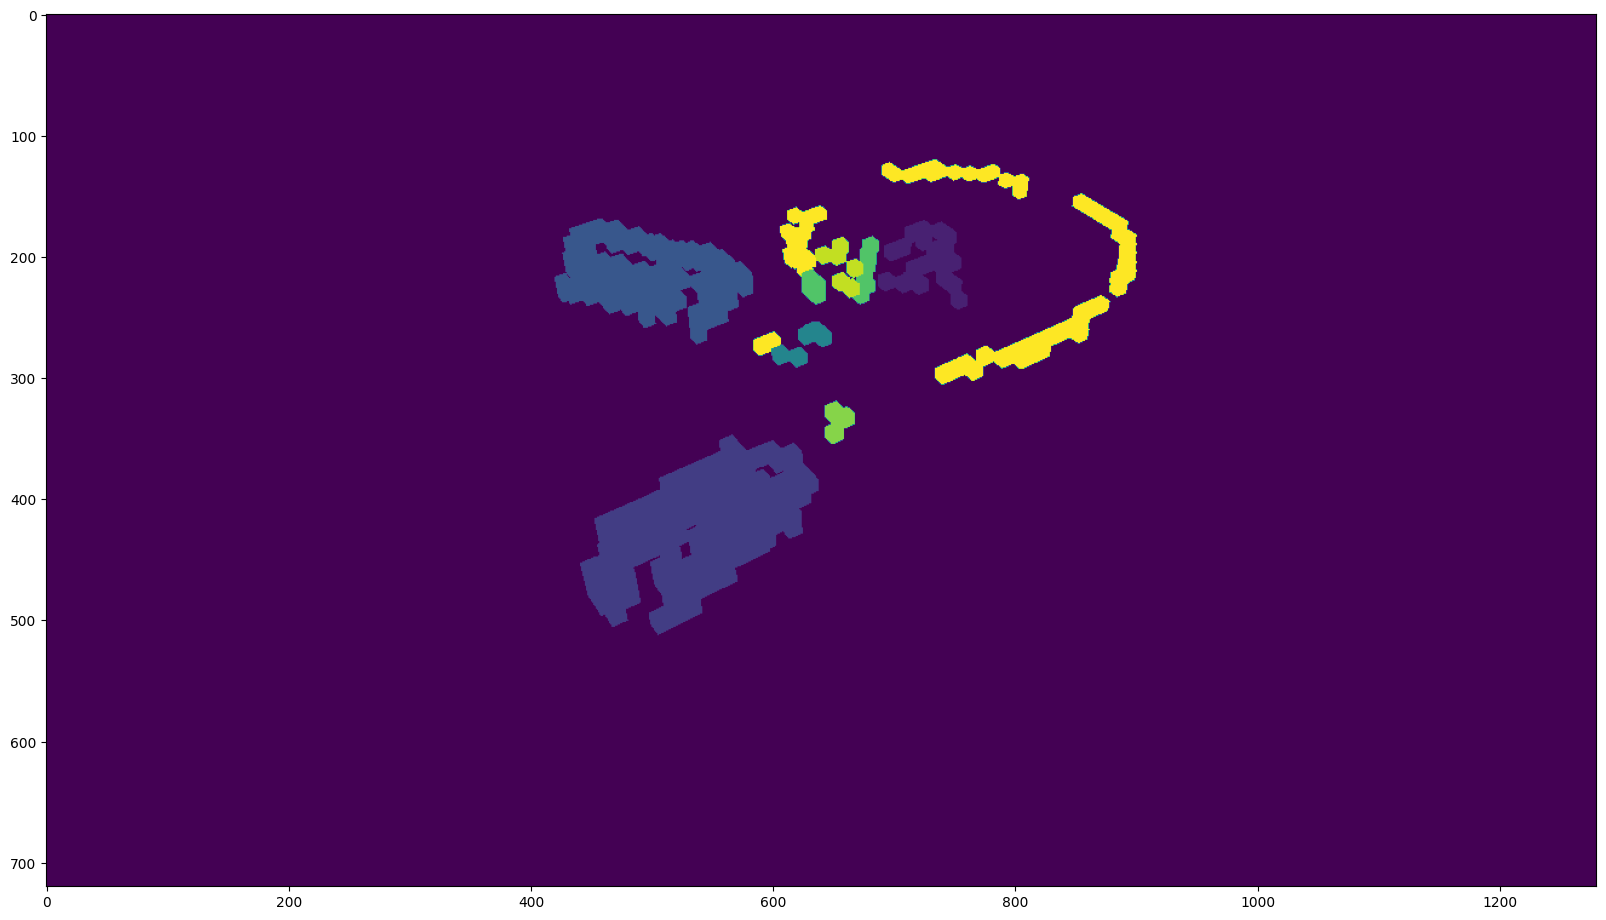

generating prompts
Initial size: 1558
Initial size: 1516
Initial size: 1279
Initial size: 2736
Initial size: 305
WTF


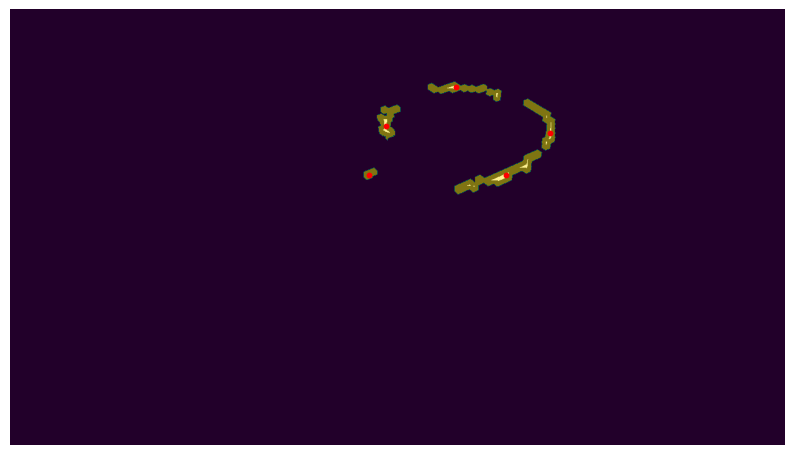

WTF


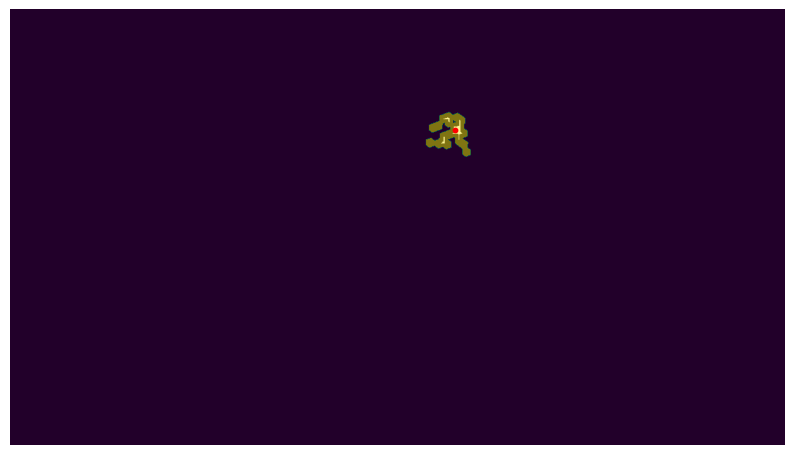

WTF


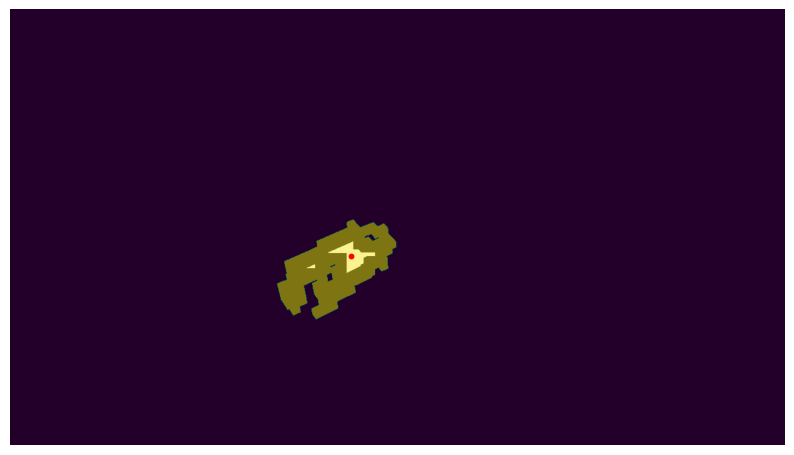

WTF


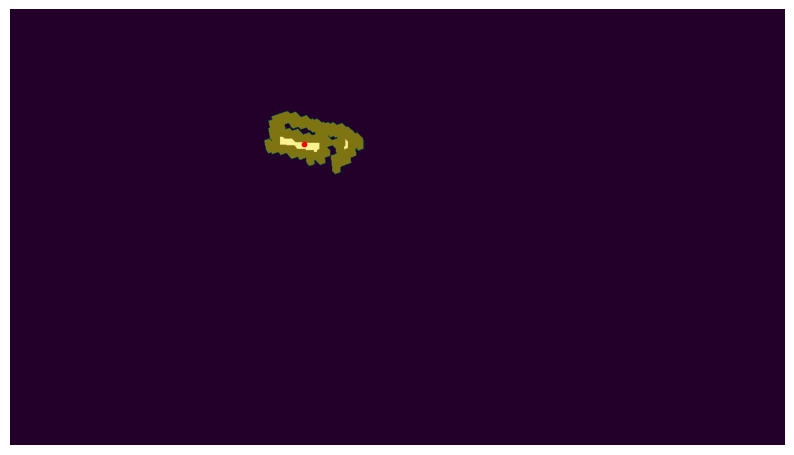

WTF


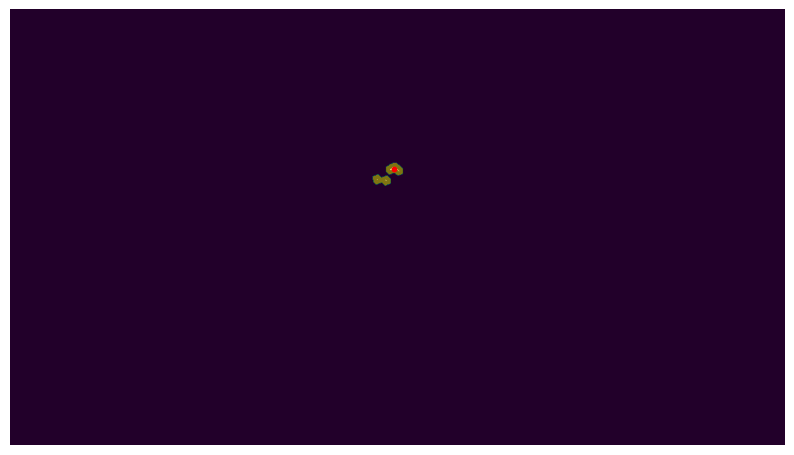

WTF


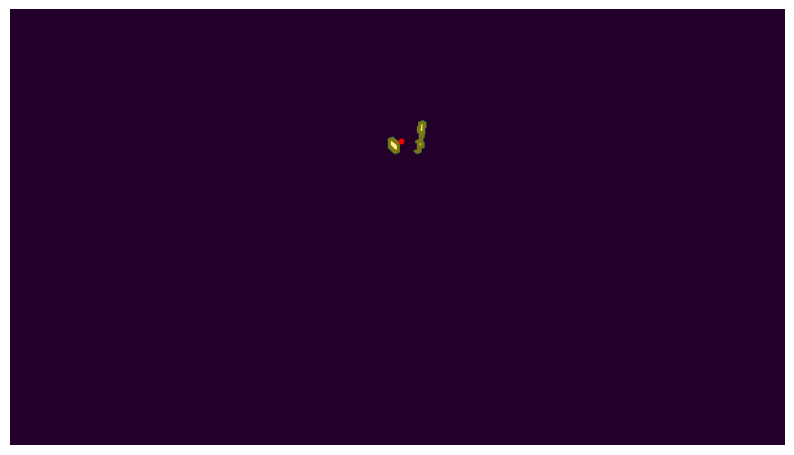

WTF


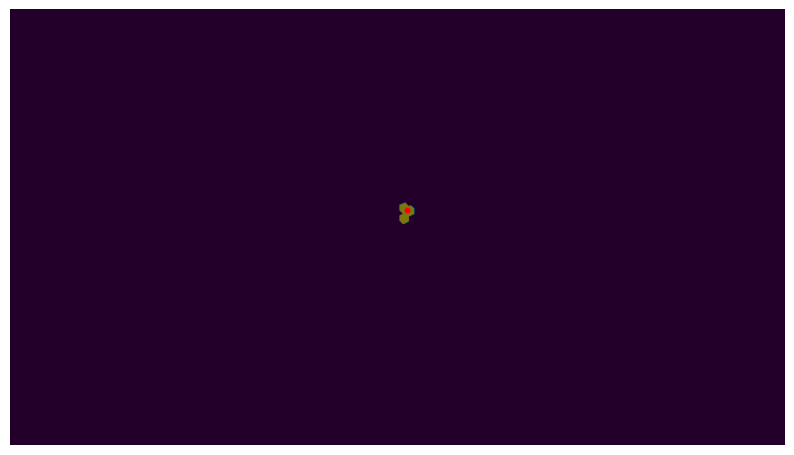

WTF


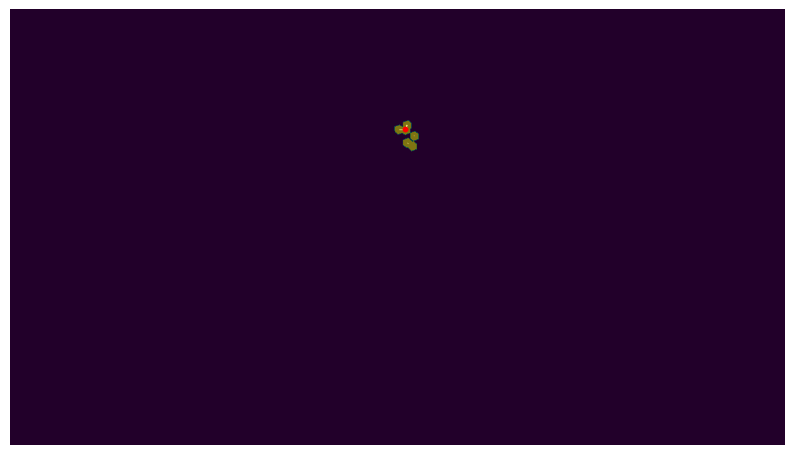

prompts generated


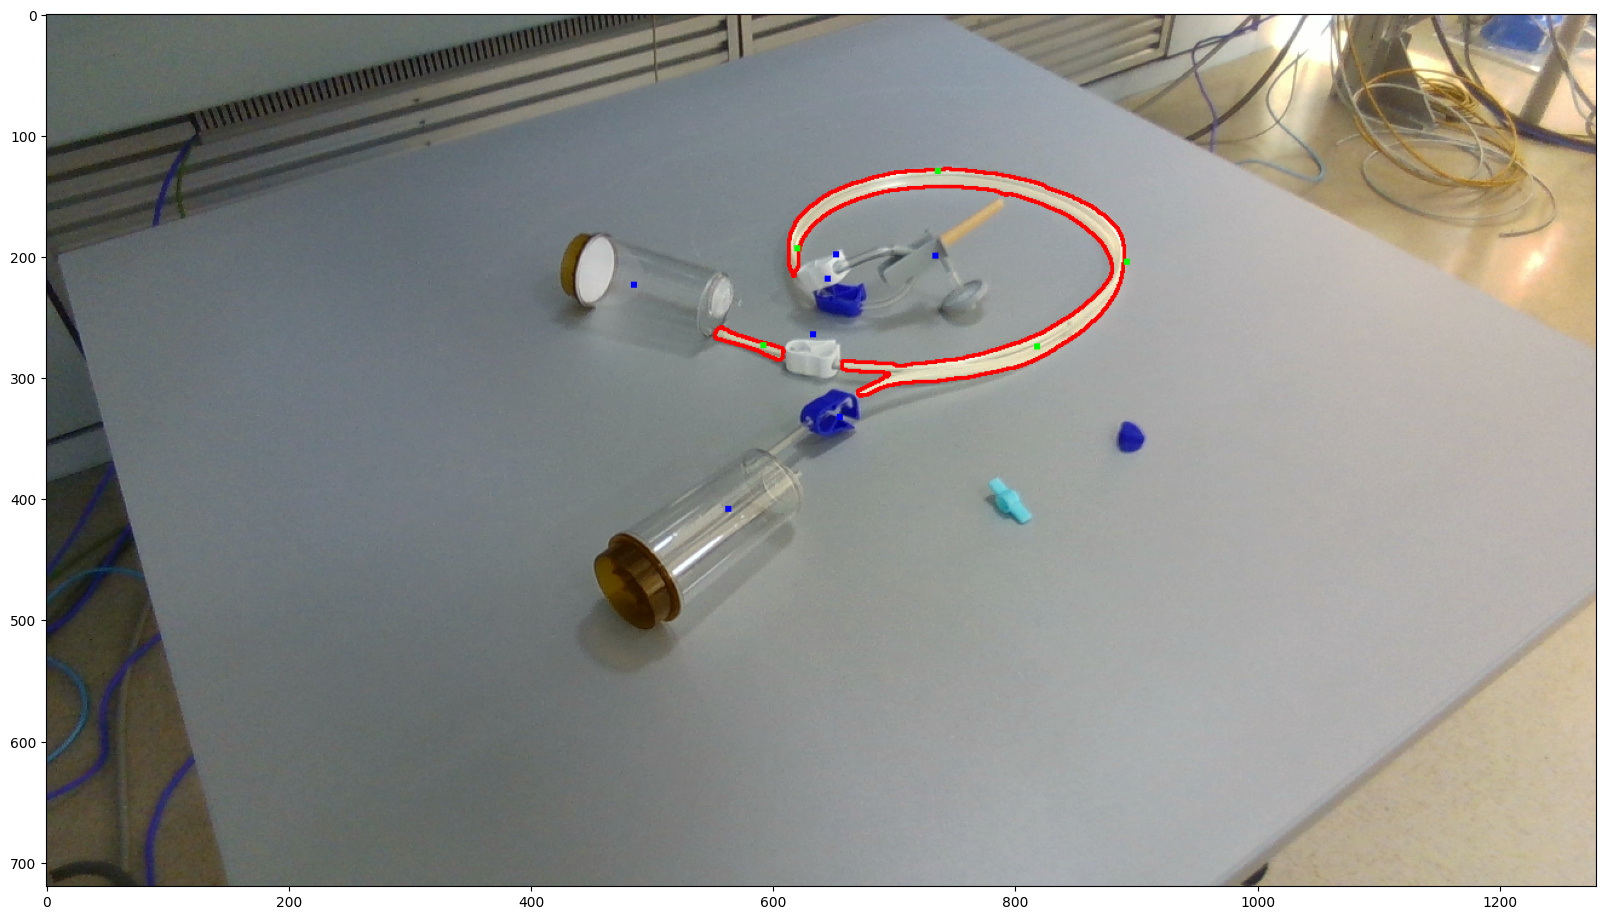

In [137]:

for image in scene.annotation_images.values():
    if image.annotation_accepted:
        continue
    rgb = cv2.imread(image.rgb_path, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    predictor.set_image(rgb)
    generate_auto_prompts(image, scene, predictor)
    break